# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [ ]:
import sys
!{sys.executable} -m pip install -U scikit-learn

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [ ]:
# save to pickle to load faster next time
#azdias.to_pickle('azdias.pkl')
#customers.to_pickle('customers.pkl')

In [2]:
# load in the pickle datasets
azdias = pd.read_pickle('azdias.pkl')
customers = pd.read_pickle('customers.pkl')

In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
# In the following cells I'll be exploring the datasets available
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
azdias.shape

(891221, 366)

In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
customers.shape

(191652, 369)

### Here, I'll explore the spreadsheets with information about the columns of the previous dataframes

In [7]:
attributes = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', header=1)

In [8]:
attributes.index = [x for x in range(0,attributes.shape[0])]

In [9]:
attributes.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [10]:
attributes.shape

(2258, 4)

#### When I opened the excel file with the attributes values, I concluded that the NaN values in the Attribute column corresponded to different values of the same attribute. That way, I filled those cells with the attribute value above in order to make it easier to access when I need to.

In [11]:
attributes['Attribute'] = attributes['Attribute'].ffill()

In [12]:
attributes.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [13]:
att_info = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', header=1)

In [14]:
att_info.index = [x for x in range(0,att_info.shape[0])]

In [15]:
att_info.head(10)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [16]:
att_info.shape

(313, 4)

#### When I first loaded the azdias and customer dataframes a warning on columns 18 and 19 was raised. So I'll analyze them in order to fix them

In [17]:
cols = azdias.columns[18:20]
cols

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [18]:
# Let's see what the spreadsheets with info of each attribute says about these columns
att_info[att_info['Attribute'] == cols[0]]

,Information level,Attribute,Description,Additional notes
85,Microcell (RR4_ID),CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,New German CAMEO Typology established together...


In [19]:
attributes[attributes['Attribute'] == cols[0]]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,NaN,1,upper class
53,CAMEO_DEUG_2015,NaN,2,upper middleclass
54,CAMEO_DEUG_2015,NaN,3,established middleclasse
55,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,NaN,5,active middleclass
57,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
58,CAMEO_DEUG_2015,NaN,7,lower middleclass
59,CAMEO_DEUG_2015,NaN,8,working class
60,CAMEO_DEUG_2015,NaN,9,urban working class


In [20]:
azdias[cols[0]].unique()

array([nan, '8', '4', '2', '6', '1', '9', '5', '7', '3', 'X'],
      dtype=object)

#### From the description of the column 'CAMEO_DEUG_2015', the values vary from -1 (uknown) to 9, so I'll replace the 'X' values with NaN

In [21]:
azdias[cols[0]] = azdias[cols[0]].replace('X',np.nan)

In [22]:
customers[cols[0]] = customers[cols[0]].replace('X',np.nan)

In [23]:
azdias[cols[0]].unique()

array([nan, '8', '4', '2', '6', '1', '9', '5', '7', '3'], dtype=object)

#### Let's perform a similar analysys to the 'CAMEO_INTL_2015' column

In [24]:
azdias[cols[1]].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32',
       'XX'], dtype=object)

#### In this case, the column has 'XX' values that I'll replace for NaN

In [25]:
attributes[attributes['Attribute'] == cols[1]]

,Attribute,Description,Value,Meaning


#### Here, we can see that 'CAMEO_INTL_2015' doesn't exist in the attributes dataframe. After looking the spreadsheet, I concluded that the column is called 'CAMEO_DEUINTL_2015' in the spreadsheet. That way, I'll rename that column in the azdias and customers dataframes.

In [26]:
azdias.rename(columns = {cols[1]:'CAMEO_DEUINTL_2015'}, inplace=True)

In [27]:
azdias.columns[19]

'CAMEO_DEUINTL_2015'

In [28]:
azdias['CAMEO_DEUINTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32',
       'XX'], dtype=object)

In [29]:
azdias['CAMEO_DEUINTL_2015'] = azdias['CAMEO_DEUINTL_2015'].replace('XX',np.nan)

In [30]:
azdias['CAMEO_DEUINTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [31]:
# performing the same in the customers dataframe
customers[cols[1]].unique()

array(['13', nan, '34', '24', '41', '23', '15', '55', '14', '22', '43',
       '51', '33', '25', '44', '54', '32', '12', '35', '31', '45', '52',
       'XX'], dtype=object)

In [32]:
customers.rename(columns = {cols[1]:'CAMEO_DEUINTL_2015'}, inplace=True)

In [33]:
customers['CAMEO_DEUINTL_2015'] = customers['CAMEO_DEUINTL_2015'].replace('XX',np.nan)

In [34]:
customers['CAMEO_DEUINTL_2015'].unique()

array(['13', nan, '34', '24', '41', '23', '15', '55', '14', '22', '43',
       '51', '33', '25', '44', '54', '32', '12', '35', '31', '45', '52'],
      dtype=object)

#### The 'DIAS Attributes - Values 2017' shows us that exists values tha means 'unknown' for most of the attributes. Those values can be 0, -1 or even a list of values. In order to make these unknown values uniform, I'll replace them with NaN also.

In [35]:
# List of labels of unknown values
u_val = ['unknown', 'unknown / no main age detectable' , 'no transaction known']

In [36]:
# Dataframe with the unknown values for each attribute
# We can see that sometimes a attribute will have more than one value for 'unknown'
u_attributes = attributes[attributes['Meaning'].isin(u_val)]
u_attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


In [37]:
# Creating a dictionary with the unknow values of each attribute
u_val_dict = dict()
for idx, row in u_attributes.iterrows():
    u_val_dict[row['Attribute']] = str(row['Value']).split(',')

In [38]:
u_val_dict

{'AGER_TYP': ['-1'],
 'ALTERSKATEGORIE_GROB': ['-1', ' 0'],
 'ALTER_HH': ['0'],
 'ANREDE_KZ': ['-1', ' 0'],
 'BALLRAUM': ['-1'],
 'BIP_FLAG': ['-1'],
 'CAMEO_DEUG_2015': ['-1'],
 'CAMEO_DEUINTL_2015': ['-1'],
 'CJT_GESAMTTYP': ['0'],
 'D19_BANKEN_DIREKT_RZ': ['0'],
 'D19_BANKEN_GROSS_RZ': ['0'],
 'D19_BANKEN_LOKAL_RZ': ['0'],
 'D19_BANKEN_REST_RZ': ['0'],
 'D19_BEKLEIDUNG_GEH_RZ': ['0'],
 'D19_BEKLEIDUNG_REST_RZ': ['0'],
 'D19_BILDUNG_RZ': ['0'],
 'D19_BIO_OEKO_RZ': ['0'],
 'D19_BUCH_RZ': ['0'],
 'D19_DIGIT_SERV_RZ': ['0'],
 'D19_DROGERIEARTIKEL_RZ': ['0'],
 'D19_ENERGIE_RZ': ['0'],
 'D19_FREIZEIT_RZ': ['0'],
 'D19_GARTEN_RZ': ['0'],
 'D19_HANDWERK_RZ': ['0'],
 'D19_HAUS_DEKO_RZ': ['0'],
 'D19_KINDERARTIKEL_RZ': ['0'],
 'D19_KK_KUNDENTYP': ['-1'],
 'D19_KOSMETIK_RZ': ['0'],
 'D19_LEBENSMITTEL_RZ': ['0'],
 'D19_LOTTO_RZ': ['0'],
 'D19_NAHRUNGSERGAENZUNG_RZ': ['0'],
 'D19_RATGEBER_RZ': ['0'],
 'D19_REISEN_RZ': ['0'],
 'D19_SAMMELARTIKEL_RZ': ['0'],
 'D19_SCHUHE_RZ': ['0'],
 'D19_SONSTIGE

In [39]:
# Creating a function that replaces the values on the dict to NaN for each attribute
def unknown_to_nan(df, unknown_dict):
    '''
    Replace the values of each key of the dict in the input df by NaN values
    
    Input:
        df - Dataframe with values that need to be replaced
        unknown_dict - dictionary with the unknown values mapped for each attribute
        
    Output:
        None
    '''
    
    for att in unknown_dict:
        if att in df.columns:
            val_array = unknown_dict[att]
            for val in val_array:
                df[att].replace(int(val), np.NaN, inplace=True)

In [40]:
# Applying the function to azdias and customers dataframes
unknown_to_nan(azdias, u_val_dict)

In [41]:
unknown_to_nan(customers, u_val_dict)

In [42]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [43]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


### Addressing the columns with high percentage of missing values

#### In order to do that I'll create some visualizations about the percentage of missing values in the columns of azdias and customers dataframes

In [44]:
azdias_null = azdias.isnull().sum()/len(azdias)*100

In [45]:
azdias_null = azdias_null.sort_values(ascending = False)

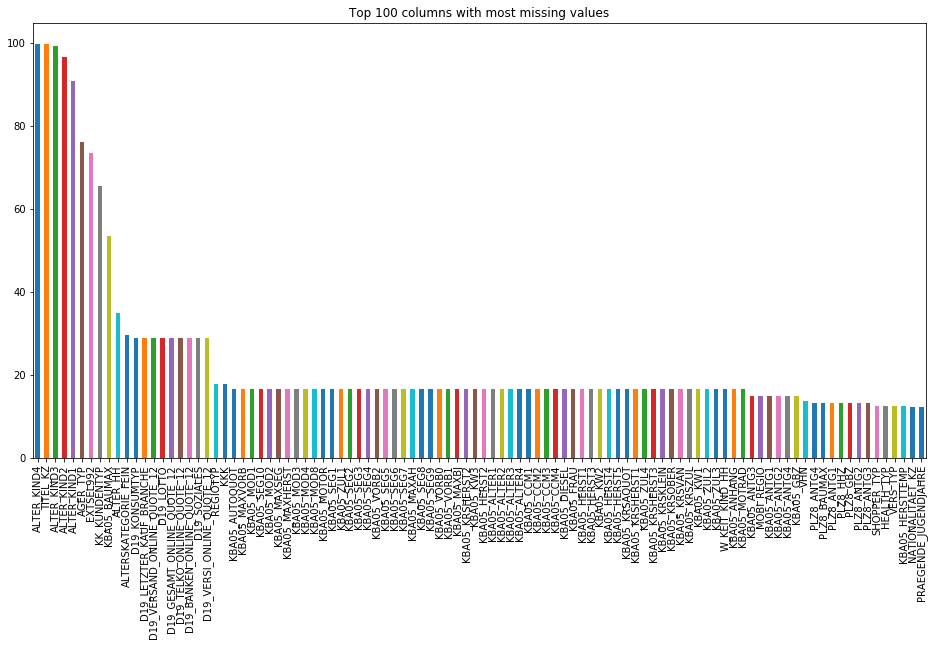

In [46]:
azdias_null.head(100).plot(kind = 'bar', title = 'Top 100 columns with most missing values', figsize = (16,8))

In [47]:
azdias_null.head(20)

ALTER_KIND4                    99.864792
TITEL_KZ                       99.757636
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
AGER_TYP                       76.019640
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
KBA05_BAUMAX                   53.468668
ALTER_HH                       34.813699
ALTERSKATEGORIE_FEIN           29.504130
D19_KONSUMTYP                  28.849522
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_LOTTO                      28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
dtype: float64

In [48]:
customers_null = customers.isnull().sum()/len(customers)*100

In [49]:
customers_null = customers_null.sort_values(ascending = False)

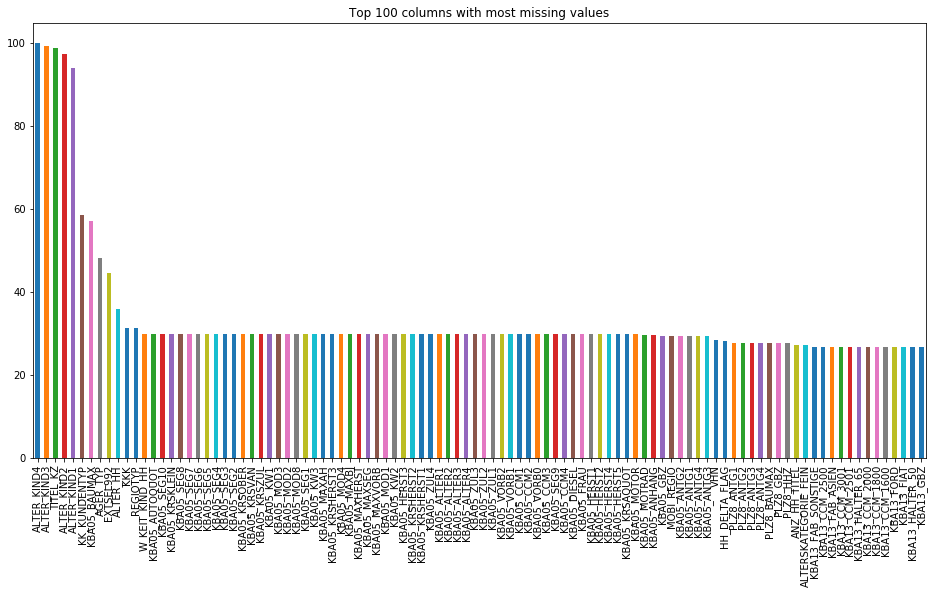

In [50]:
customers_null.head(100).plot(kind = 'bar', title = 'Top 100 columns with most missing values', figsize = (16,8))

In [51]:
customers_null.head(20)

ALTER_KIND4       99.876860
ALTER_KIND3       99.334732
TITEL_KZ          98.793647
ALTER_KIND2       97.338927
ALTER_KIND1       93.860748
KK_KUNDENTYP      58.406382
KBA05_BAUMAX      57.153069
AGER_TYP          48.059504
EXTSEL992         44.498883
ALTER_HH          35.870745
KKK               31.340137
REGIOTYP          31.340137
W_KEIT_KIND_HH    29.708534
KBA05_AUTOQUOT    29.696533
KBA05_SEG10       29.696012
KBA05_KRSKLEIN    29.696012
KBA05_SEG8        29.696012
KBA05_SEG7        29.696012
KBA05_SEG6        29.696012
KBA05_SEG5        29.696012
dtype: float64

In [52]:
# azdias columns with more than 20% of missing values
azdias_null[azdias_null>20]

ALTER_KIND4                    99.864792
TITEL_KZ                       99.757636
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
AGER_TYP                       76.019640
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
KBA05_BAUMAX                   53.468668
ALTER_HH                       34.813699
ALTERSKATEGORIE_FEIN           29.504130
D19_KONSUMTYP                  28.849522
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_LOTTO                      28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
dtype: float64

In [53]:
# customers columns with more than 20% of missing values
customers_null[customers_null>20]

ALTER_KIND4                    99.876860
ALTER_KIND3                    99.334732
TITEL_KZ                       98.793647
ALTER_KIND2                    97.338927
ALTER_KIND1                    93.860748
KK_KUNDENTYP                   58.406382
KBA05_BAUMAX                   57.153069
AGER_TYP                       48.059504
EXTSEL992                      44.498883
ALTER_HH                       35.870745
KKK                            31.340137
REGIOTYP                       31.340137
W_KEIT_KIND_HH                 29.708534
KBA05_AUTOQUOT                 29.696533
KBA05_SEG10                    29.696012
KBA05_KRSKLEIN                 29.696012
KBA05_SEG8                     29.696012
KBA05_SEG7                     29.696012
KBA05_SEG6                     29.696012
KBA05_SEG5                     29.696012
KBA05_SEG4                     29.696012
KBA05_SEG3                     29.696012
KBA05_SEG2                     29.696012
KBA05_KRSOBER                  29.696012
KBA05_KRSVAN    

In [54]:
len(azdias_null[azdias_null>20])

20

In [55]:
len(customers_null[customers_null>20])

259

In [56]:
# I'll drop from both azdias and customers dataframes the set of columns with more than 20% of missing values AND that exists in both dataframe
drop_cols = list(set(azdias_null[azdias_null>20].index) & set(customers_null[customers_null>20].index))

In [57]:
azdias_null[drop_cols]

D19_GESAMT_ONLINE_QUOTE_12     28.849522
AGER_TYP                       76.019640
D19_LETZTER_KAUF_BRANCHE       28.849522
ALTERSKATEGORIE_FEIN           29.504130
D19_SOZIALES                   28.849522
KBA05_BAUMAX                   53.468668
ALTER_KIND1                    90.904837
TITEL_KZ                       99.757636
D19_BANKEN_ONLINE_QUOTE_12     28.849522
ALTER_KIND4                    99.864792
KK_KUNDENTYP                   65.596749
ALTER_HH                       34.813699
D19_LOTTO                      28.849522
EXTSEL992                      73.399639
D19_KONSUMTYP                  28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
ALTER_KIND2                    96.690047
ALTER_KIND3                    99.307691
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
dtype: float64

In [58]:
len(drop_cols)

20

In [59]:
# Let's drop from azdias all columns with 20% or more of missing values
azdias = azdias.drop(drop_cols, axis = 1)
customers = customers.drop(drop_cols, axis = 1)

In [60]:
azdias.shape, customers.shape

((891221, 346), (191652, 349))

#### Now all column of azdias has less than 20% of missing values

### Addressing rows with high percentage of missing values

In [61]:
# Creating a dataframe with the percentage of missing values per row
rows_missing = azdias.isnull().sum(axis=1)/azdias.shape[1]*100

In [62]:
rows_missing = rows_missing.sort_values(ascending=False)
rows_missing.head(10)

472919    71.387283
732775    70.809249
643174    70.809249
281305    70.520231
80444     70.520231
212053    70.520231
15284     70.520231
826869    70.520231
469054    70.520231
15680     70.520231
dtype: float64

In [63]:
# Number of rows in azdias with less than 20% of the values missing
len(rows_missing[rows_missing<20])

776566

In [64]:
# Dropping all the rows with more than 20% of values missing
azdias = azdias[rows_missing<20]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [65]:
azdias.shape

(776566, 346)

In [66]:
# Let's perform the same process in the customers dataframe
rows_custom_missing = customers.isnull().sum(axis=1)/customers.shape[1]*100

In [67]:
rows_custom_missing = rows_custom_missing.sort_values(ascending=False)
rows_custom_missing.head(10)

128189    70.773639
134876    70.487106
90306     69.914040
33815     69.914040
74012     69.914040
51669     69.914040
117708    69.914040
89983     69.914040
2794      69.914040
13188     69.914040
dtype: float64

In [68]:
len(rows_custom_missing[rows_custom_missing<20])

139162

In [69]:
customers = customers[rows_custom_missing<20]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [70]:
customers.shape

(139162, 349)

### Other columns to drop and re-encoding attributes

- Before going foward, we still need to address some columns
- By exploring the 'DIAS Attributes - Values 2017' spreadsheet, we can see that some other columns can be dropped and others need to be reencoded

#### First, let's check which attributes are common to azdias and customers and exist information about them in the spreadsheets

In [71]:
common_cols = list(set(azdias.columns) & set(customers.columns) & set(attributes['Attribute']))

In [72]:
azdias = azdias[common_cols]
azdias.shape

(776566, 265)

#### In the case of the customers dataframe we will keep the columns ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'] that are exclusive of it

In [73]:
exclusive_cols = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
exclusive_cols

['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

In [74]:
common_cols.extend(exclusive_cols)

In [75]:
customers = customers[common_cols]

In [76]:
customers.shape

(139162, 268)

#### In order to finish the cleaning, I'll perform modifications in the following attributes

- OST_WEST_KZ: This column is binary (indicating the former GDR/FRG) and have as values W (west) and O (east). That way I'll reencode it to 0,1 values

- CAMEO_DEU_2015: This column has strings (codes) as values and is a more detailed version of CAMEO_DEUG_2015, so I'll drop this column

- LP_FAMILIE_GROB: In the DIAS Attributes spreadsheet, this column's values can vary from 1 to 11 but they correspond to only 5 categories about family compasition. I'll create dummy variables for the 5 categories

- LP_STATUS_GROB: Same situation as the column above. This column correspond to social status, thus is categorical and I'll create dummy variables for corresponding categories

- ('LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN'): These columns are more detailed versions (they have 10 or more values) of categorical attributes. Since they add no more significant information, I'll drop them.

- PRAEGENDE_JUGENDJAHRE: This column refers to the dominating movement in the person's youth (avantgarde or mainstream), but it contains too many labels (15). That way I 'll re-encode it to binary (avantgarde:0, mainstream:1)


In [77]:
# Let's use a map function to replace the values in OST_WEST_KZ for 1's and 0's
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'O':0, 'W':1})

In [78]:
azdias['OST_WEST_KZ'].unique()

array([1, 0])

In [79]:
# Drop the columns I explained above
more_cols = ['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN']
azdias.drop(more_cols, axis = 1, inplace= True)
azdias.shape

(776566, 261)

#### The LP_FAMILIE_GROB column has values in the interval 0 to 5, but in the attributes spreadsheet the values are in the interval 1 to 11. That means the numbers in the dataframe correspond to the categories in the 'Meaning' column of the spreadsheet. Also, the value 0 has no meaning, so I'll change it to NaN

In [80]:
azdias['LP_FAMILIE_GROB'].unique()

array([ 3.,  1.,  0.,  5.,  2.,  4., nan])

In [81]:
# Create dummy variables for LP_FAMILIE_GROB
# Function to categorizes the values in LP_FAMILIE_GROB
def categorize_LP(val):
    new_val = np.nan
    
    if val == 1:
        new_val = 'single'
        
    elif val == 2:
        new_val = 'couple'
        
    elif val == 3:
        new_val = 'single parent'
        
    elif val == 4:
        new_val = 'family'
        
    elif val == 5:
        new_val = 'multiperson household'
        
    elif val == 0:
        new_val = np.nan
        
    return new_val

In [82]:
azdias['LP_FAMILIE_GROB'] = azdias['LP_FAMILIE_GROB'].apply(lambda x: categorize_LP(x))

In [83]:
# get the dummy variables
dummy = pd.get_dummies(azdias['LP_FAMILIE_GROB'], prefix='LP_FAMILIE_GROB')
dummy.head()

,LP_FAMILIE_GROB_couple,LP_FAMILIE_GROB_family,LP_FAMILIE_GROB_multiperson household,LP_FAMILIE_GROB_single,LP_FAMILIE_GROB_single parent
1,0,0,0,0,1
2,0,0,0,1,0
3,0,0,0,0,0
4,0,0,1,0,0
5,0,0,0,1,0


In [84]:
azdias.drop('LP_FAMILIE_GROB', axis=1, inplace=True)

In [85]:
azdias = pd.concat([azdias,dummy], axis = 1)
azdias.head()

,D19_VERSAND_ANZ_12,SEMIO_REL,KBA05_CCM1,KBA05_KW2,KBA13_AUDI,KBA13_SEG_KOMPAKTKLASSE,KBA13_KMH_251,KBA13_BJ_2000,KBA05_ALTER3,KBA05_ZUL1,...,KBA05_SEG5,KBA13_BJ_2006,PRAEGENDE_JUGENDJAHRE,KBA13_CCM_1000,NATIONALITAET_KZ,LP_FAMILIE_GROB_couple,LP_FAMILIE_GROB_family,LP_FAMILIE_GROB_multiperson household,LP_FAMILIE_GROB_single,LP_FAMILIE_GROB_single parent
1,0,4,1.0,3.0,4.0,5.0,1.0,3.0,1.0,5.0,...,2.0,3.0,14.0,0.0,1.0,0,0,0,0,1
2,0,3,5.0,2.0,3.0,1.0,1.0,2.0,3.0,2.0,...,1.0,5.0,15.0,1.0,1.0,0,0,0,1,0
3,0,2,2.0,4.0,5.0,4.0,1.0,2.0,3.0,3.0,...,2.0,3.0,8.0,4.0,1.0,0,0,0,0,0
4,6,4,4.0,2.0,4.0,3.0,1.0,3.0,4.0,3.0,...,2.0,2.0,8.0,5.0,1.0,0,0,1,0,0
5,0,7,1.0,5.0,4.0,2.0,1.0,2.0,2.0,3.0,...,1.0,3.0,3.0,3.0,1.0,0,0,0,1,0


#### Following, we have a similar situation in the LP_STATUS_GROB attribute

In [86]:
azdias['LP_STATUS_GROB'].unique()

array([ 1.,  2.,  4.,  5.,  3., nan])

In [87]:
# Function to categorizes the values in LP_STATUS_GROB
def categorize_LP_STATUS(val):
    new_val = np.nan
    
    if val == 1:
        new_val = 'low-income earners'
        
    elif val == 2:
        new_val = 'average earners'
        
    elif val == 3:
        new_val = 'independants'
        
    elif val == 4:
        new_val = 'houseowners'
        
    elif val == 5:
        new_val = 'top earners '
        
    return new_val

In [88]:
azdias['LP_STATUS_GROB'] = azdias['LP_STATUS_GROB'].apply(lambda x: categorize_LP_STATUS(x))

In [89]:
azdias['LP_STATUS_GROB'].unique()

array(['low-income earners', 'average earners', 'houseowners',
       'top earners ', 'independants', nan], dtype=object)

In [90]:
# get the dummy variables for LP_STATUS_GROB
dummy = pd.get_dummies(azdias['LP_STATUS_GROB'], prefix='LP_STATUS_GROB')
dummy.head()

,LP_STATUS_GROB_average earners,LP_STATUS_GROB_houseowners,LP_STATUS_GROB_independants,LP_STATUS_GROB_low-income earners,LP_STATUS_GROB_top earners
1,0,0,0,1,0
2,1,0,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0


In [91]:
azdias.drop('LP_STATUS_GROB', axis=1, inplace=True)
azdias = pd.concat([azdias,dummy], axis = 1)
azdias.head()

,D19_VERSAND_ANZ_12,SEMIO_REL,KBA05_CCM1,KBA05_KW2,KBA13_AUDI,KBA13_SEG_KOMPAKTKLASSE,KBA13_KMH_251,KBA13_BJ_2000,KBA05_ALTER3,KBA05_ZUL1,...,LP_FAMILIE_GROB_couple,LP_FAMILIE_GROB_family,LP_FAMILIE_GROB_multiperson household,LP_FAMILIE_GROB_single,LP_FAMILIE_GROB_single parent,LP_STATUS_GROB_average earners,LP_STATUS_GROB_houseowners,LP_STATUS_GROB_independants,LP_STATUS_GROB_low-income earners,LP_STATUS_GROB_top earners
1,0,4,1.0,3.0,4.0,5.0,1.0,3.0,1.0,5.0,...,0,0,0,0,1,0,0,0,1,0
2,0,3,5.0,2.0,3.0,1.0,1.0,2.0,3.0,2.0,...,0,0,0,1,0,1,0,0,0,0
3,0,2,2.0,4.0,5.0,4.0,1.0,2.0,3.0,3.0,...,0,0,0,0,0,0,1,0,0,0
4,6,4,4.0,2.0,4.0,3.0,1.0,3.0,4.0,3.0,...,0,0,1,0,0,1,0,0,0,0
5,0,7,1.0,5.0,4.0,2.0,1.0,2.0,2.0,3.0,...,0,0,0,1,0,1,0,0,0,0


In [92]:
# function to re-encode the column to binary (avantgarde:0, mainstream:1)
def encode_PRAEGENDE_JUGENDJAHRE(val):
    new_val = np.nan
    
    if val in [1,3,5,8,10,12,14]:
        new_val = 1
        
    elif val in [2,4,6,7,9,11,13,15]:
        new_val = 0
        
    return new_val

In [93]:
azdias['PRAEGENDE_JUGENDJAHRE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_PRAEGENDE_JUGENDJAHRE(x))

In [94]:
azdias['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 1.,  0., nan])

#### I'll perform the the same process in the customers dataframe. In order to do that, I created a function that includes the steps above

In [95]:
def final_cleaning(df, cols = []):
    
    '''
    Function to execute the final cleaning steps
    
    Inputs:
    
        df - dataframe to be cleaned
        cols - chosen columns to be dropped
        
    Output: 
        df_cleaned - cleaned dataframe
    
    '''
    
    # Dealing with the OST_WEST_KZ column
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'O':0, 'W':1})
    
    # Dropping additional columns that add no significant information 
    df_cleaned = df.drop(cols, axis = 1)
    print(df_cleaned.shape)
    
    # Categorizing and creating dummy variables for LP_FAMILIE_GROB and LP_STATUS_GROB using functions created earlier
    df_cleaned['LP_FAMILIE_GROB'] = df_cleaned['LP_FAMILIE_GROB'].apply(lambda x: categorize_LP(x))
    
    dummy_1 = pd.get_dummies(df_cleaned['LP_FAMILIE_GROB'], prefix='LP_FAMILIE_GROB')
    df_cleaned.drop('LP_FAMILIE_GROB', axis=1, inplace=True)
    df_cleaned = pd.concat([df_cleaned, dummy_1], axis = 1)
    print(df_cleaned.shape)
    
    df_cleaned['LP_STATUS_GROB'] = df_cleaned['LP_STATUS_GROB'].apply(lambda x: categorize_LP_STATUS(x))
    
    dummy_2 = pd.get_dummies(df_cleaned['LP_STATUS_GROB'], prefix='LP_STATUS_GROB')
    df_cleaned.drop('LP_STATUS_GROB', axis=1, inplace=True)
    df_cleaned = pd.concat([df_cleaned, dummy_2], axis = 1)
    print(df_cleaned.shape)
    
    df_cleaned['PRAEGENDE_JUGENDJAHRE'] = df_cleaned['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_PRAEGENDE_JUGENDJAHRE(x))
    
    return df_cleaned

In [96]:
customers_clean = final_cleaning(customers, more_cols)

(139162, 268)
(139162, 272)
(139162, 276)


In [2]:
customers_clean.shape

NameError: name 'customers_clean' is not defined

In [98]:
# save backups of the cleaned dataframes to pickle to load faster next time
azdias.to_pickle('azdias_cleaned.pkl')
customers_clean.to_pickle('customers_cleaned.pkl')

In [2]:
# load in the pickle datasets
azdias = pd.read_pickle('azdias_cleaned.pkl')
customers = pd.read_pickle('customers_cleaned.pkl')

In [4]:
azdias.shape, customers.shape

((776566, 269), (139162, 276))

### Impute missing values and Feature scaling

In [4]:
# imputing NaN values with 'median' strategy
imp_med = SimpleImputer(missing_values=np.nan, strategy='median')

In [5]:
azdias_imp = pd.DataFrame(imp_med.fit_transform(azdias))

In [7]:
azdias.head()

,D19_VERSAND_ANZ_12,SEMIO_REL,KBA05_CCM1,KBA05_KW2,KBA13_AUDI,KBA13_SEG_KOMPAKTKLASSE,KBA13_KMH_251,KBA13_BJ_2000,KBA05_ALTER3,KBA05_ZUL1,...,LP_FAMILIE_GROB_couple,LP_FAMILIE_GROB_family,LP_FAMILIE_GROB_multiperson household,LP_FAMILIE_GROB_single,LP_FAMILIE_GROB_single parent,LP_STATUS_GROB_average earners,LP_STATUS_GROB_houseowners,LP_STATUS_GROB_independants,LP_STATUS_GROB_low-income earners,LP_STATUS_GROB_top earners
1,0,4,1.0,3.0,4.0,5.0,1.0,3.0,1.0,5.0,...,0,0,0,0,1,0,0,0,1,0
2,0,3,5.0,2.0,3.0,1.0,1.0,2.0,3.0,2.0,...,0,0,0,1,0,1,0,0,0,0
3,0,2,2.0,4.0,5.0,4.0,1.0,2.0,3.0,3.0,...,0,0,0,0,0,0,1,0,0,0
4,6,4,4.0,2.0,4.0,3.0,1.0,3.0,4.0,3.0,...,0,0,1,0,0,1,0,0,0,0
5,0,7,1.0,5.0,4.0,2.0,1.0,2.0,2.0,3.0,...,0,0,0,1,0,1,0,0,0,0


In [10]:
# Performing the same in the customers dataframe
cols = ['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN']
customers.drop(cols, axis = 1, inplace = True)

In [13]:
exclusive_cols = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
ex_customers = customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]

In [14]:
customers.drop(exclusive_cols, axis = 1, inplace = True)

In [15]:
customers_imp = pd.DataFrame(imp_med.fit_transform(customers))

In [18]:
azdias_imp.head()

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
0,0.0,4.0,1.0,3.0,4.0,5.0,1.0,3.0,1.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,3.0,5.0,2.0,3.0,1.0,1.0,2.0,3.0,2.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,2.0,2.0,4.0,5.0,4.0,1.0,2.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,6.0,4.0,4.0,2.0,4.0,3.0,1.0,3.0,4.0,3.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,7.0,1.0,5.0,4.0,2.0,1.0,2.0,2.0,3.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
customers_imp.head()

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
0,0.0,2.0,3.0,3.0,4.0,3.0,1.0,2.0,4.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,2.0,3.0,4.0,3.0,1.0,3.0,2.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,3.0,3.0,4.0,2.0,3.0,1.0,2.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3.0,4.0,2.0,4.0,2.0,3.0,1.0,3.0,4.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,4.0,3.0,2.0,3.0,3.0,1.0,2.0,3.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
scaler = StandardScaler()

In [21]:
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imp))

In [23]:
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_imp))

In [24]:
azdias_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
0,-0.553353,0.003436,-1.885695,0.002580,0.992335,2.011722,-0.398698,0.007676,-1.907942,1.960138,...,-0.374884,-0.255689,-0.559222,-1.007884,5.317693,-0.523681,-0.482458,-0.223771,1.218568,-0.40382
1,-0.553353,-0.519805,1.949113,-0.971532,-0.003921,-1.916798,-0.398698,-0.994697,0.003427,-0.956123,...,-0.374884,-0.255689,-0.559222,0.992178,-0.188051,1.909561,-0.482458,-0.223771,-0.820635,-0.40382
2,-0.553353,-1.043045,-0.926993,0.976693,1.988591,1.029592,-0.398698,-0.994697,0.003427,0.015964,...,-0.374884,-0.255689,-0.559222,-1.007884,-0.188051,-0.523681,2.072719,-0.223771,-0.820635,-0.40382
3,4.525190,0.003436,0.990411,-0.971532,0.992335,0.047462,-0.398698,0.007676,0.959112,0.015964,...,-0.374884,-0.255689,1.788199,-1.007884,-0.188051,1.909561,-0.482458,-0.223771,-0.820635,-0.40382
4,-0.553353,1.573157,-1.885695,1.950805,0.992335,-0.934668,-0.398698,-0.994697,-0.952257,0.015964,...,-0.374884,-0.255689,-0.559222,0.992178,-0.188051,1.909561,-0.482458,-0.223771,-0.820635,-0.40382


In [25]:
customers_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
0,-0.753274,-0.813432,0.231225,-0.077902,0.805269,0.278513,-0.459114,-0.751580,0.854916,0.267617,...,2.049102,-0.24155,-0.825747,-0.609796,-0.102719,-0.402079,-0.537168,-0.354717,-0.396151,1.311214
1,-0.753274,-1.499727,-0.813336,-0.077902,0.805269,0.278513,-0.459114,0.299537,-1.103678,-0.805674,...,-0.488019,-0.24155,-0.825747,1.639892,-0.102719,-0.402079,-0.537168,-0.354717,-0.396151,1.311214
2,-0.753274,-0.127137,0.231225,0.971260,-1.255732,0.278513,-0.459114,-0.751580,-0.124381,-0.805674,...,-0.488019,-0.24155,-0.825747,-0.609796,-0.102719,-0.402079,1.861617,-0.354717,-0.396151,-0.762652
3,1.465946,0.559158,-0.813336,0.971260,-1.255732,0.278513,-0.459114,0.299537,0.854916,0.267617,...,-0.488019,-0.24155,1.211025,-0.609796,-0.102719,-0.402079,-0.537168,-0.354717,2.524290,-0.762652
4,-0.753274,0.559158,0.231225,-1.127064,-0.225232,0.278513,-0.459114,-0.751580,-0.124381,-0.805674,...,2.049102,-0.24155,-0.825747,-0.609796,-0.102719,-0.402079,-0.537168,2.819149,-0.396151,-0.762652


In [26]:
# Saving the scaled datframes to pickle
azdias_scaled.to_pickle('azdias_scaled.pkl')
customers_scaled.to_pickle('customers_scaled.pkl')

In [6]:
# Loading the pickle files if needed
azdias_scaled = pd.read_pickle('azdias_scaled.pkl')
customers_scaled = pd.read_pickle('customers_scaled.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [5]:
# importing modules
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Principal Component Analysis (PCA)
After cleaning and scaling the datasets, it's time to apply unsupervised learning technique to the data in order to understand the relationship between the general population and the existing customers of the company. First we'll use Principal Component Analysis to reduce the number of features to the ones that best explain the whole dataset in order to make it easier to explore and visualize

In [7]:
# Apply PCA to azdias and customers dataframes and create some visualizations
pca = PCA()

In [8]:
# fit the model to the datasets and create a plot of the cumulative variance explained by the number of features using the explained_variance_ratio_ attribute
azdias_pca = pca.fit(azdias_scaled)

In [9]:
azdias_pca.explained_variance_ratio_

array([8.10760083e-02, 6.09383477e-02, 3.99343439e-02, 3.30967914e-02,
       2.75670564e-02, 2.40997823e-02, 2.40048563e-02, 2.11001842e-02,
       1.90242289e-02, 1.71508494e-02, 1.62507764e-02, 1.42057216e-02,
       1.31478208e-02, 1.22059625e-02, 1.15933826e-02, 1.12402611e-02,
       1.06286342e-02, 1.02509888e-02, 9.85497490e-03, 9.59678423e-03,
       9.10687613e-03, 9.04989600e-03, 8.59090851e-03, 8.19296091e-03,
       8.03219483e-03, 7.93745681e-03, 7.53952342e-03, 7.37216395e-03,
       7.23548219e-03, 6.95136207e-03, 6.89336203e-03, 6.41921945e-03,
       6.33666312e-03, 6.08204780e-03, 5.99770145e-03, 5.84411113e-03,
       5.78673446e-03, 5.59297537e-03, 5.56336226e-03, 5.38437271e-03,
       5.36001758e-03, 5.26258426e-03, 5.23183559e-03, 5.22124975e-03,
       5.08568105e-03, 5.01413694e-03, 4.95182352e-03, 4.90411035e-03,
       4.85104859e-03, 4.65476983e-03, 4.58462563e-03, 4.54523415e-03,
       4.53508152e-03, 4.51775714e-03, 4.43592778e-03, 4.32011892e-03,
      

Text(0, 0.5, 'Cumulative Variance')

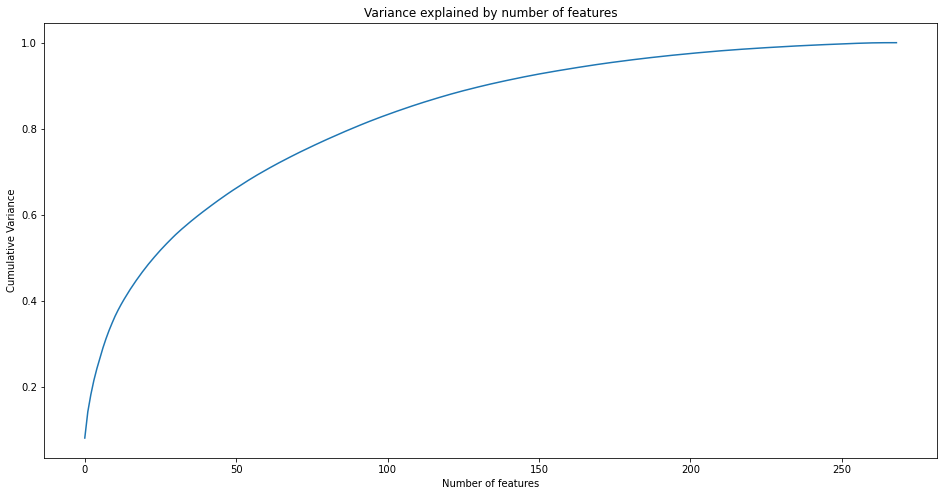

In [10]:
exp_var = np.cumsum(azdias_pca.explained_variance_ratio_)
figure = plt.figure(figsize = (16,8))
plt.plot(exp_var)
plt.title('Variance explained by number of features')
plt.xlabel('Number of features')
plt.ylabel('Cumulative Variance')

In [11]:
# Let's get the number of features that explain at least 95% of the variance of the dataset
n_components = len(exp_var[np.cumsum(azdias_pca.explained_variance_ratio_) <= 0.95])
n_components

170

#### As we can see, we were able to reduce the number of features to 170 and still keep 95% of the variance of the whole dataset

In [12]:
# I'll use the number found above to reduce azdias
azdias_reduced = PCA(n_components = n_components).fit_transform(azdias_scaled)

In [13]:
def pca_plot(df_pca):
    '''
    Function to plot the graph of Cumulative Variance x Number of features of a fitted PCA model
    
    Input:
        df_pca - fitted PCA model on a dataset
        
    Output: 
        None
    
    '''
    exp_var = np.cumsum(azdias_pca.explained_variance_ratio_)
    figure = plt.figure(figsize = (16,8))
    plt.plot(exp_var)
    plt.title('Variance explained by number of features')
    plt.xlabel('Number of features')
    plt.ylabel('Cumulative Variance')
    plt.show()
    

In [14]:
# Adding up the steps above in a function and apply to customers_scaled
def perform_pca(df, n_components):
    '''
    Function to perform Principal Component Analysis on a dataframe keeping a given number of components
    
    Input:
        df - dataframe to perform dimensionality reduction
        n_components - number of features to keep
        
    Output:
        df_reduced - dataframe with reduced dimensions
    
    '''
    
    df_reduced = PCA(n_components = n_components).fit_transform(df)
    return df_reduced

In [15]:
customers_pca = PCA().fit(customers_scaled)

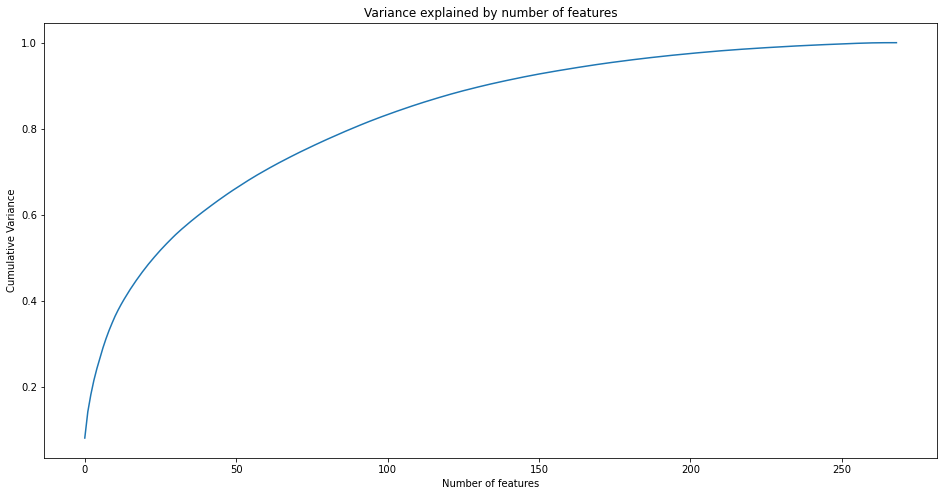

In [16]:
pca_plot(customers_pca)

In [17]:
customers_reduced = perform_pca(customers_scaled, 170)
customers_reduced.shape

(139162, 170)

### K-means clustering
After reducing the dimension of the datasets, I'll cluster the data into different segments using the k-means algorithm. It will be used different numbers of clusters and will be selected the 'optimal' number of clusters by the 'Elbow Method'

#### The Elbow Method
As said before, the Elbow Method helps to find the optimal number of clusters that I will use on our K-means algorithm to improve some metric. In this case, I will minimize the 'distortion' variation of the dataset, defined as mean sum of squared distances to centers of the clusters.

In order to do that, I'll plot distortion x number of clusters and find the number of clusters of the point in the curve which the curve starts to decrease in a linear fashion.

The idea is to find the number of cluster that by adding one more cluster to the existing ones will not improve the distortion variation, in other words, the 'elbow of the curve'.

In [18]:
def perform_kmeans(df, k_start, k_end):
    '''
    Function that performs k-means clusterization on a dataset using values fo k
    changing from k_start to k_end and retrieves the scores of each one
    
    Inputs:
        df - dataset with reduced dimensions
        k_start - initial value for the parameter k
        k_end - final value for the parameter k
        
    Output:
        distortion - list with the distorion of each clusterization measured by the inertia_ attribute

    '''
    distortion = []
    
    for k in range(k_start, k_end+1):
        kmeans = KMeans(k, random_state=0)
        model_k = kmeans.fit(df)
        distortion.append(model_k.inertia_)
        
    return distortion

In [19]:
azdias_distortion = perform_kmeans(azdias_reduced, 2, 20)

In [22]:
len(azdias_distortion)

19

In [23]:
def elbow_curve(distortion):
    '''
    Function to plot the Sum os Squared Distances to the closest centroid center 'distortion' x number of clusters
    
    Input:
        distortion - list of distortion values calculated before
        
    Output: None
    
    '''
    ind = np.arange(2,21)
    figure = plt.figure(figsize = (16,8))
    plt.plot(ind, distortion, linestyle= "--",marker = "o", color="orange")
    
    plt.title('Elbow Curve')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of Squared Distances')
    plt.show()

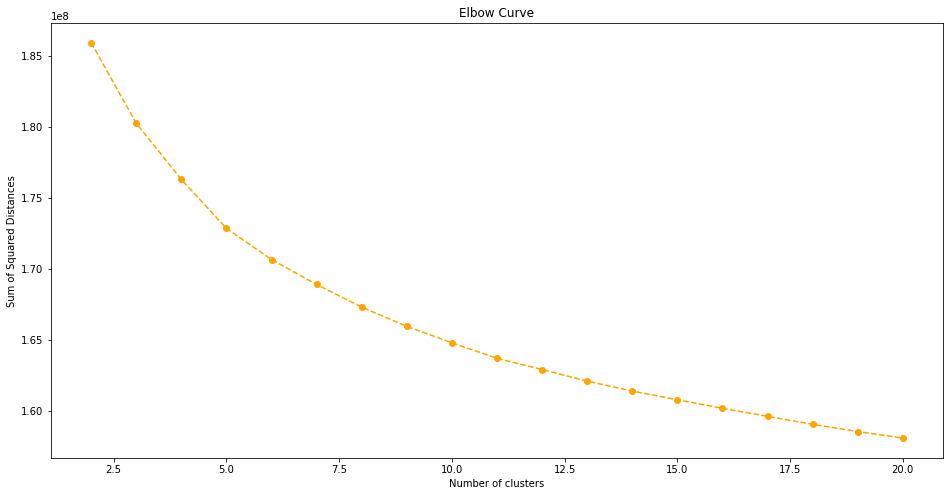

In [24]:
elbow_curve(azdias_distortion)

#### In order to find the 'elbow point' of the curve, I calculated the point with the greatest distance to the line connecting the starting and end points of the elbow curve as shown below

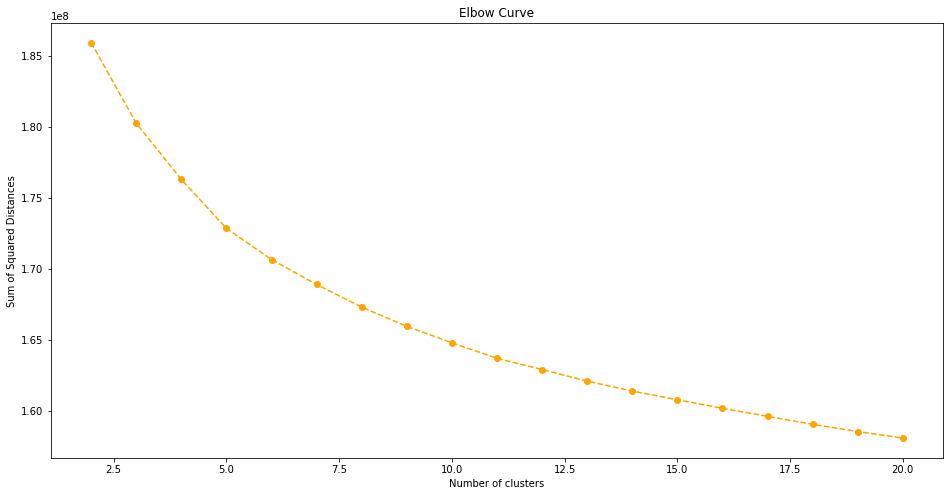

In [25]:
elbow_curve(azdias_distortion)

In [26]:
# Create function to calculate the distance 
def distance(a_0, a_1, p):
    '''
    Function that calculates the distance between a point 'x,y' on the elbow curve to the line conecting
    the starting and end points of the elbow curve
    
    Inputs:
        a_0 'list' - starting point of the elbow curve
        a_1 'list' - ending point of the elbow curve
        p 'list' - point from which calculate the distance
        
    Output:
        d - calculated distance
    
    '''
    
    x_0 = a_0[0]
    y_0 = a_0[1]
    x_1 = a_1[0]
    y_1 = a_1[1]
    x = p[0]
    y = p[1]
    
    numerator = abs((y_1-y_0)*x - (x_1-x_0)*y + x_1*y_0 - x_0*y_1)
    denominator = np.sqrt((y_1 - y_0)**2 + (x_1-x_0)**2)
    
    d = numerator/denominator
    return d
    

In [27]:
a = pd.Series(azdias_distortion, index = np.arange(2,21))

In [28]:
a0 = [2,a[2]]
a20 = [20,a[20]]
p = [10,a[10]]
distance(a0,a20,p)

5.664406819734745

In [29]:
dist_dict = dict()
for p0,p1 in zip(np.arange(2,21), a):
    dist_dict[p0] = distance(a0,a20, [p0,p1])

In [30]:
dist_dict

{2: 2.137809299861565e-15,
 3: 2.6649857609279075,
 4: 4.228073213092633,
 5: 5.451698256787038,
 6: 5.873680403331152,
 7: 6.009674390256364,
 8: 6.0394183463351245,
 9: 5.915208958651008,
 10: 5.664406819734745,
 11: 5.370796136374672,
 12: 4.882024938563427,
 13: 4.408000044110904,
 14: 3.861403303753321,
 15: 3.2578585768298582,
 16: 2.64513927841729,
 17: 2.0115505970877963,
 18: 1.3754702775487821,
 19: 0.7042080756404049,
 20: 1.4964665099030953e-14}

#### As we can see, the highest distance occurs when the number of clusters equals 8, so that is the number of clusters I will adopt

In [31]:
# Using n_clusters = 8 to azdias and customers dataframes
kmeans = KMeans(n_clusters = 8)

In [32]:
azdias_predicted = kmeans.fit_predict(azdias_reduced)
azdias_clusters = pd.DataFrame(azdias_predicted, columns=['Cluster'])

In [33]:
customers_predicted = kmeans.fit_predict(customers_reduced)
customers_clusters = pd.DataFrame(customers_predicted, columns=['Cluster'])

In [34]:
population_clustered = azdias_clusters.value_counts().sort_index()

In [35]:
customers_clustered = customers_clusters.value_counts().sort_index()

In [36]:
# Creating a dataframe with information about total population and customers
relation_df = pd.concat([population_clustered, customers_clustered], axis=1).reset_index()
relation_df.columns = ['Cluster', 'Population', 'Customers']

In [37]:
relation_df

,Cluster,Population,Customers
0,0,104414,22665
1,1,96933,21287
2,2,113138,12919
3,3,86083,10726
4,4,58573,20928
5,5,60797,17420
6,6,147317,6669
7,7,109311,26548


#### Now I'll create 2 other columns with the share that each cluster represent to the total dataset and plot so I can see the relationship

In [38]:
relation_df['pop_pct'] = (relation_df.Population/relation_df.Population.sum())*100

In [39]:
relation_df['custom_pct'] = (relation_df.Customers/relation_df.Customers.sum())*100

Text(0.5, 1.0, 'Share of Population and Customers in each Cluster')

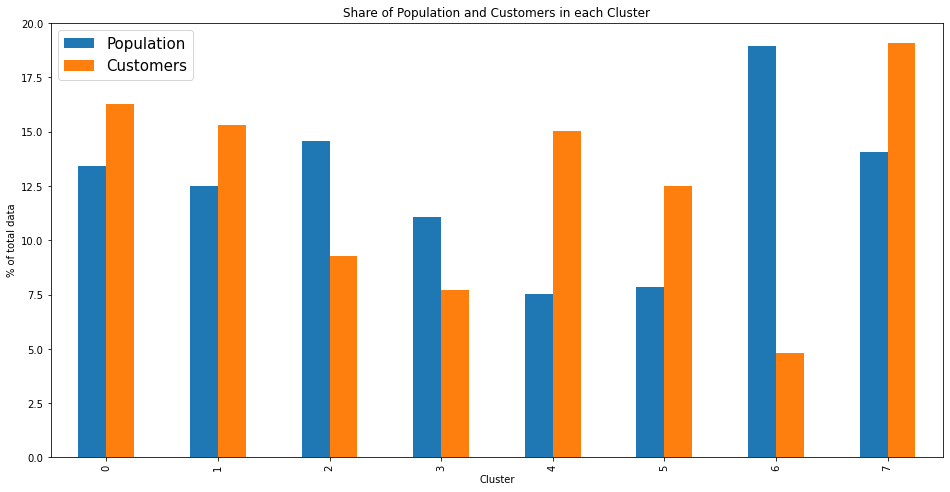

In [40]:
relation_df[['pop_pct', 'custom_pct']].plot(kind = 'bar', figsize = (16,8))
plt.xlabel('Cluster')
plt.ylabel('% of total data')
plt.legend(('Population', 'Customers'), fontsize = 15)
plt.title('Share of Population and Customers in each Cluster')

### Conclusions

From the 'Elbow Curve' analysis, I've found that 8 was the optimal number of clusters, so I used this number to train my Kmeans model and then used it to cluster both general population and customers datasets in those 8 clusters.
As shown in the graph above, the general population and the customers are distributed along the clusters in different ways. 
In Population data, all clusters are well represented and only clusters number 1 and 6 shows less tha 10% of representation.
In customers data, we have some clusters represented very differently from population data. We can see that cluster number 7 is over represented (more than 20%) while cluster number 6 only shows less than 5% of representation.
Besides the differences, the results can be explained by the differences in sizes of the datasets. The Population data is very large and the data is more or less equally spread. In the other hand, it's expected that the customers data represents only a small portion of the general population, so the data is more imbalanced distributed.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [41]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv'

In [42]:
# Reading pickle files in order to load faster
mailout_train = pd.read_pickle('mailout_train.pkl')
mailout_test = pd.read_pickle('mailout_test.pkl')

In [43]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


#### Checking the balance between positive and negative responses with the "RESPONSE" column

In [48]:
balance_dict = {'no' : (len(mailout_train.RESPONSE[mailout_train['RESPONSE'] == 0]))/len(mailout_train['RESPONSE']),'yes' : len(mailout_train.RESPONSE[mailout_train['RESPONSE'] == 1])/len(mailout_train['RESPONSE'])}


In [50]:
balance = pd.Series(balance_dict)

<AxesSubplot:>

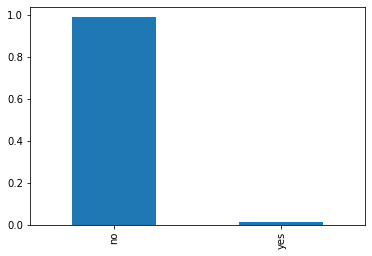

In [54]:
balance.transpose().plot(kind = 'bar')

In [55]:
balance

no     0.987617
yes    0.012383
dtype: float64

#### As we can see, the RESPONSE dat is very un balanced with almost 0 individual (1.2%) responding positive to the campaign

In [56]:
# storing the 'RESPONSE' in a variable
mailout_train_X = mailout_train.drop('RESPONSE', axis = 1)
mailout_train_y = mailout_train['RESPONSE']

In [57]:
mailout_train_X.shape

(42962, 366)

In [58]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [59]:
mailout_test.shape

(42833, 366)

### Cleaning and Preprocessing
In this part I'll create a function that summarizes all the cleaning steps performed in part 0 and apply it to the train dataset

In [60]:
attributes = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', header=1)
attributes.index = [x for x in range(0,attributes.shape[0])]
attributes['Attribute'] = attributes['Attribute'].ffill()
attributes.drop('Unnamed: 0', axis = 1, inplace = True)
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


In [61]:
att_info = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', header=1)
att_info.index = [x for x in range(0,att_info.shape[0])]
att_info.drop('Unnamed: 0', axis = 1, inplace = True)
att_info.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [62]:
# List of labels of unknown values
u_val = ['unknown', 'unknown / no main age detectable' , 'no transaction known']

In [63]:
# Dataframe with the unknown values for each attribute
# We can see that sometimes a attribute will have more than one value for 'unknown'
u_attributes = attributes[attributes['Meaning'].isin(u_val)]
u_attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


In [64]:
# Creating a dictionary with the unknow values of each attribute
u_val_dict = dict()
for idx, row in u_attributes.iterrows():
    u_val_dict[row['Attribute']] = str(row['Value']).split(',')

In [65]:
u_val_dict

{'AGER_TYP': ['-1'],
 'ALTERSKATEGORIE_GROB': ['-1', ' 0'],
 'ALTER_HH': ['0'],
 'ANREDE_KZ': ['-1', ' 0'],
 'BALLRAUM': ['-1'],
 'BIP_FLAG': ['-1'],
 'CAMEO_DEUG_2015': ['-1'],
 'CAMEO_DEUINTL_2015': ['-1'],
 'CJT_GESAMTTYP': ['0'],
 'D19_BANKEN_DIREKT_RZ': ['0'],
 'D19_BANKEN_GROSS_RZ': ['0'],
 'D19_BANKEN_LOKAL_RZ': ['0'],
 'D19_BANKEN_REST_RZ': ['0'],
 'D19_BEKLEIDUNG_GEH_RZ': ['0'],
 'D19_BEKLEIDUNG_REST_RZ': ['0'],
 'D19_BILDUNG_RZ': ['0'],
 'D19_BIO_OEKO_RZ': ['0'],
 'D19_BUCH_RZ': ['0'],
 'D19_DIGIT_SERV_RZ': ['0'],
 'D19_DROGERIEARTIKEL_RZ': ['0'],
 'D19_ENERGIE_RZ': ['0'],
 'D19_FREIZEIT_RZ': ['0'],
 'D19_GARTEN_RZ': ['0'],
 'D19_HANDWERK_RZ': ['0'],
 'D19_HAUS_DEKO_RZ': ['0'],
 'D19_KINDERARTIKEL_RZ': ['0'],
 'D19_KK_KUNDENTYP': ['-1'],
 'D19_KOSMETIK_RZ': ['0'],
 'D19_LEBENSMITTEL_RZ': ['0'],
 'D19_LOTTO_RZ': ['0'],
 'D19_NAHRUNGSERGAENZUNG_RZ': ['0'],
 'D19_RATGEBER_RZ': ['0'],
 'D19_REISEN_RZ': ['0'],
 'D19_SAMMELARTIKEL_RZ': ['0'],
 'D19_SCHUHE_RZ': ['0'],
 'D19_SONSTIGE

In [66]:
# Re-using the function that replaces the values on the dict to NaN for each attribute
def unknown_to_nan(df, unknown_dict):
    '''
    Replace the values of each key of the dict in the input df by NaN values
    
    Input:
        df - Dataframe with values that need to be replaced
        unknown_dict - dictionary with the unknown values mapped for each attribute
        
    Output:
        None
    '''
    
    for att in unknown_dict:
        if att in df.columns:
            val_array = unknown_dict[att]
            for val in val_array:
                df[att].replace(int(val), np.NaN, inplace=True)

In [67]:
# Create dummy variables for LP_FAMILIE_GROB
# Function to categorizes the values in LP_FAMILIE_GROB
def categorize_LP(val):
    new_val = np.nan
    
    if val == 1:
        new_val = 'single'
        
    elif val == 2:
        new_val = 'couple'
        
    elif val == 3:
        new_val = 'single parent'
        
    elif val == 4:
        new_val = 'family'
        
    elif val == 5:
        new_val = 'multiperson household'
        
    elif val == 0:
        new_val = np.nan
        
    return new_val

In [68]:
# Function to categorizes the values in LP_STATUS_GROB
def categorize_LP_STATUS(val):
    new_val = np.nan
    
    if val == 1:
        new_val = 'low-income earners'
        
    elif val == 2:
        new_val = 'average earners'
        
    elif val == 3:
        new_val = 'independants'
        
    elif val == 4:
        new_val = 'houseowners'
        
    elif val == 5:
        new_val = 'top earners '
        
    return new_val

In [69]:
# function to re-encode the column to binary (avantgarde:0, mainstream:1)
def encode_PRAEGENDE_JUGENDJAHRE(val):
    new_val = np.nan
    
    if val in [1,3,5,8,10,12,14]:
        new_val = 1
        
    elif val in [2,4,6,7,9,11,13,15]:
        new_val = 0
        
    return new_val

In [70]:
drop_cols = ['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN']

In [71]:
mailout_train_X.rename({'CAMEO_INTL_2015':'CAMEO_DEUINTL_2015'}, axis = 1, inplace = True)

In [72]:
mailout_train_X['CAMEO_DEUINTL_2015'].head()

0    34
1    32
2    14
3    14
4    41
Name: CAMEO_DEUINTL_2015, dtype: object

In [75]:
def clean_steps(df, unknown_dict, drop_cols):
    
    df_clean = df.copy()
    
    # Dealing with 'X' and 'XX' values on columns 18 and 19
    df_clean['CAMEO_DEUG_2015'] = df_clean['CAMEO_DEUG_2015'].replace('X',np.nan)
    df_clean['CAMEO_DEUINTL_2015'] = df_clean['CAMEO_DEUINTL_2015'].replace('XX',np.nan)
    
    # Replacing Unknown values with NaN 
    unknown_to_nan(df_clean, unknown_dict)
    
    # Getting rid of columns with more than 20% of missing values
    df_null = df_clean.isnull().sum()/len(df)*100
    
    cols_to_drop = list(df_null[df_null>20].index)
    df_clean.drop(cols_to_drop, axis = 1, inplace = True)
    
    # Keeping only the columns we have information about
    common_cols = list(set(df_clean.columns) & set(attributes['Attribute']))
    df_clean = df_clean[common_cols]
    
    # Dealing with the OST_WEST_KZ column
    df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].map({'O':0, 'W':1})
    
    # Dropping other columns judged to be not helpful
    df_clean.drop(drop_cols, axis = 1, inplace= True)
    print(df_clean.shape)
    
    # Categorizing and creating dummy variables for LP_FAMILIE_GROB and LP_STATUS_GROB using functions created earlier
    df_clean['LP_FAMILIE_GROB'] = df_clean['LP_FAMILIE_GROB'].apply(lambda x: categorize_LP(x))
    
    dummy_1 = pd.get_dummies(df_clean['LP_FAMILIE_GROB'], prefix='LP_FAMILIE_GROB')
    df_clean.drop('LP_FAMILIE_GROB', axis=1, inplace=True)
    df_clean = pd.concat([df_clean, dummy_1], axis = 1)
    print(df_clean.shape)
    
    df_clean['LP_STATUS_GROB'] = df_clean['LP_STATUS_GROB'].apply(lambda x: categorize_LP_STATUS(x))
    
    dummy_2 = pd.get_dummies(df_clean['LP_STATUS_GROB'], prefix='LP_STATUS_GROB')
    df_clean.drop('LP_STATUS_GROB', axis=1, inplace=True)
    df_clean = pd.concat([df_clean, dummy_2], axis = 1)
    print(df_clean.shape)
    
    df_clean['PRAEGENDE_JUGENDJAHRE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: encode_PRAEGENDE_JUGENDJAHRE(x))
    
    return df_clean
    
    

In [76]:
mailout_train_clean = clean_steps(mailout_train_X, u_val_dict, drop_cols)

(42962, 267)
(42962, 271)
(42962, 275)


In [78]:
mailout_train_clean.head()

,D19_TELKO_ANZ_24,KBA13_SEG_KLEINWAGEN,KBA05_VORB1,KBA05_MOD1,D19_VERSI_ANZ_12,KBA13_KMH_140,KBA13_CCM_3000,KBA13_ALTERHALTER_45,KBA13_BJ_2004,WOHNDAUER_2008,...,LP_FAMILIE_GROB_couple,LP_FAMILIE_GROB_family,LP_FAMILIE_GROB_multiperson household,LP_FAMILIE_GROB_single,LP_FAMILIE_GROB_single parent,LP_STATUS_GROB_average earners,LP_STATUS_GROB_houseowners,LP_STATUS_GROB_independants,LP_STATUS_GROB_low-income earners,LP_STATUS_GROB_top earners
0,0,2.0,3.0,3.0,0,4.0,3.0,4.0,4.0,9.0,...,0,0,0,1,0,1,0,0,0,0
1,1,3.0,5.0,0.0,0,4.0,2.0,3.0,3.0,9.0,...,1,0,0,0,0,0,1,0,0,0
2,0,3.0,4.0,1.0,0,1.0,2.0,4.0,3.0,9.0,...,0,0,0,0,0,0,0,0,0,1
3,0,1.0,2.0,3.0,0,5.0,5.0,1.0,3.0,9.0,...,1,0,0,0,0,1,0,0,0,0
4,0,2.0,3.0,2.0,0,1.0,4.0,4.0,1.0,9.0,...,0,0,0,1,0,0,0,1,0,0


### Imputing NaN values and scaling training data
In this part I'll finish the preparation of the train dataset by performing imputing and scaling

In [79]:
def imputing_scaling(df_clean):
    
    df = df_clean.copy()
    
    # imputing NaN values with 'median' strategy
    imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
    df_imp = pd.DataFrame(imp_med.fit_transform(df), columns = df.columns)
    
    #scaling the data
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_imp), columns = df.columns)
    
    return df_scaled
    

In [80]:
mailout_train_ready = imputing_scaling(mailout_train_clean)

In [81]:
mailout_train_ready.head()

,D19_TELKO_ANZ_24,KBA13_SEG_KLEINWAGEN,KBA05_VORB1,KBA05_MOD1,D19_VERSI_ANZ_12,KBA13_KMH_140,KBA13_CCM_3000,KBA13_ALTERHALTER_45,KBA13_BJ_2004,WOHNDAUER_2008,...,LP_FAMILIE_GROB_couple,LP_FAMILIE_GROB_family,LP_FAMILIE_GROB_multiperson household,LP_FAMILIE_GROB_single,LP_FAMILIE_GROB_single parent,LP_STATUS_GROB_average earners,LP_STATUS_GROB_houseowners,LP_STATUS_GROB_independants,LP_STATUS_GROB_low-income earners,LP_STATUS_GROB_top earners
0,-0.261030,-1.009440,0.000722,1.545158,-0.267718,1.039983,0.264691,1.005510,1.122132,0.2432,...,-0.444688,-0.157583,-0.675821,1.585374,-0.086218,1.530799,-0.499513,-0.280852,-0.502312,-0.519519
1,2.450371,0.062714,2.215992,-1.157883,-0.267718,1.039983,-0.534105,-0.001453,-0.038106,0.2432,...,2.248768,-0.157583,-0.675821,-0.630766,-0.086218,-0.653254,2.001951,-0.280852,-0.502312,-0.519519
2,-0.261030,0.062714,1.108357,-0.256869,-0.267718,-1.355585,-0.534105,1.005510,-0.038106,0.2432,...,-0.444688,-0.157583,-0.675821,-0.630766,-0.086218,-0.653254,-0.499513,-0.280852,-0.502312,1.924856
3,-0.261030,-2.081595,-1.106913,1.545158,-0.267718,1.838505,1.862282,-2.015379,-0.038106,0.2432,...,2.248768,-0.157583,-0.675821,-0.630766,-0.086218,1.530799,-0.499513,-0.280852,-0.502312,-0.519519
4,-0.261030,-1.009440,0.000722,0.644144,-0.267718,-1.355585,1.063486,1.005510,-2.358582,0.2432,...,-0.444688,-0.157583,-0.675821,1.585374,-0.086218,-0.653254,-0.499513,3.560591,-0.502312,-0.519519


In [82]:
# saving the preprocessed train dataset to pickle
# mailout_train_ready.to_pickle('mailout_train_ready.pkl')

### Creating the model

In [87]:
# Import needed modules
from time import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

#### The creation of the model will have the following steps: try different models, choose the one with the best ROC score and then perform hyperparameter tuning on the choosen one

#### a. Try different models

In [88]:
# Split the train data for validation
X_train, X_val, y_train, y_val = train_test_split(mailout_train_ready, mailout_train_y, stratify=mailout_train_y, test_size=0.2, random_state=12)

In [89]:
# function to train and predict the models
def test_model(model, X_train, y_train, X_test, y_test):
    '''
    Function to fit a model and predict over a dataset given train and test partitions.
    Returns the ROC score of the model
    
    Inputs:
        model - machine learning model object
        X_train - train data
        y_train - train response dat
        X_test - test data
        y_test - test response data
        
    Outputs:
        roc_score, accuracy, time_passed
    
    '''
    start = time()
    model = model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time()
    time_passed = end-start
    
    return roc_score, accuracy, time_passed
  

In [90]:
# Selected models to try out
models = [("LogisticRegression", LogisticRegression()),
         ("DecisionTreeClassifier", DecisionTreeClassifier()),
         ("NaiveBayes", GaussianNB()),
         ("RandomForestClassifier", RandomForestClassifier()),
         ("GBC", GradientBoostingClassifier())]

In [114]:
# Create a dataframe with the results
result_dict = {"Model":[],
           "Accuracy": [],
          "ROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc_score, accuracy, time_passed = test_model(model, X_train, y_train, X_val, y_val)
    result_dict["Model"].append(name)
    result_dict["Accuracy"].append(accuracy)
    result_dict["ROC_score"].append(roc_score)
    result_dict["Time_in_sec"].append(time_passed)

C:\Users\isabh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### b. Display the results in order to choose the best model for tuning

In [115]:
result_df = pd.DataFrame.from_dict(result_dict, orient='index').transpose()
result_df

,Model,Accuracy,ROC_score,Time_in_sec
0,LogisticRegression,0.987664,0.619271,0.79002
1,DecisionTreeClassifier,0.971605,0.48385,1.98518
2,NaiveBayes,0.869778,0.584017,0.270534
3,RandomForestClassifier,0.987781,0.511594,7.29047
4,GBC,0.987083,0.616473,33.2092


#### The model with the best pair Accuracy, ROC_score is GradientBoostingClassifier, so I'll perform the tuning on it

#### c. GridSearch on GradientBoostingClassifier

In [93]:
param_grid = [
    {'loss': ['deviance'],
              'max_depth': [3,5],
              'learning_rate': [0.1, 0.2],
              'n_estimators': [100],
              'random_state': [2]
             }
    ]

In [94]:
gbc_grid = GridSearchCV(estimator = GradientBoostingClassifier(), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)

In [95]:
gbc_grid.fit(X_train,y_train)
gbc_grid.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  2.6min remaining:   39.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.0min finished


{'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'n_estimators': 100,
 'random_state': 2}

In [96]:
gbc_grid.best_score_

0.5952727943899329

In [97]:
best_model = gbc_grid.best_estimator_

In [98]:
# Check the ROC score of the best model on validation data
gbc_pred = best_model.predict_proba(X_val)[:,1]
print(roc_auc_score(y_val, gbc_pred))

0.6164433506517182


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [99]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv'

In [100]:
mailout_test.shape

(42833, 366)

In [101]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [102]:
# Storing the LNR column in a variable
mailout_test_LNR = mailout_test['LNR']

### Clean and preprocessing test data

In [103]:
mailout_test.rename({'CAMEO_INTL_2015':'CAMEO_DEUINTL_2015'}, axis = 1, inplace = True)

In [104]:
mailout_test_clean = clean_steps(mailout_test, u_val_dict, drop_cols)

(42833, 267)
(42833, 271)
(42833, 275)


In [105]:
mailout_test_clean.head()

,D19_TELKO_ANZ_24,KBA13_SEG_KLEINWAGEN,KBA05_VORB1,KBA05_MOD1,D19_VERSI_ANZ_12,KBA13_KMH_140,KBA13_CCM_3000,KBA13_ALTERHALTER_45,KBA13_BJ_2004,WOHNDAUER_2008,...,LP_FAMILIE_GROB_couple,LP_FAMILIE_GROB_family,LP_FAMILIE_GROB_multiperson household,LP_FAMILIE_GROB_single,LP_FAMILIE_GROB_single parent,LP_STATUS_GROB_average earners,LP_STATUS_GROB_houseowners,LP_STATUS_GROB_independants,LP_STATUS_GROB_low-income earners,LP_STATUS_GROB_top earners
0,0,3.0,3.0,4.0,0,1.0,4.0,4.0,4.0,9.0,...,1,0,0,0,0,0,0,0,0,1
1,0,1.0,4.0,1.0,0,4.0,3.0,3.0,3.0,9.0,...,0,0,0,1,0,0,0,0,1,0
2,0,2.0,2.0,4.0,0,4.0,3.0,3.0,3.0,9.0,...,0,0,1,0,0,0,0,0,0,1
3,0,4.0,3.0,0.0,0,1.0,2.0,1.0,2.0,9.0,...,0,0,0,0,0,1,0,0,0,0
4,1,2.0,3.0,3.0,0,1.0,1.0,5.0,4.0,9.0,...,0,0,1,0,0,0,1,0,0,0


In [106]:
mailout_test_ready = imputing_scaling(mailout_test_clean)

In [107]:
mailout_test_ready.head()

,D19_TELKO_ANZ_24,KBA13_SEG_KLEINWAGEN,KBA05_VORB1,KBA05_MOD1,D19_VERSI_ANZ_12,KBA13_KMH_140,KBA13_CCM_3000,KBA13_ALTERHALTER_45,KBA13_BJ_2004,WOHNDAUER_2008,...,LP_FAMILIE_GROB_couple,LP_FAMILIE_GROB_family,LP_FAMILIE_GROB_multiperson household,LP_FAMILIE_GROB_single,LP_FAMILIE_GROB_single parent,LP_STATUS_GROB_average earners,LP_STATUS_GROB_houseowners,LP_STATUS_GROB_independants,LP_STATUS_GROB_low-income earners,LP_STATUS_GROB_top earners
0,-0.25776,0.072490,0.001236,2.449606,-0.263894,-1.361656,1.073351,1.010350,1.140694,0.244893,...,2.257511,-0.158292,-0.681378,-0.631117,-0.08771,-0.641835,-0.505299,-0.279225,-0.509264,1.921718
1,-0.25776,-2.073298,1.104062,-0.246213,-0.263894,1.023516,0.270493,0.001178,-0.027435,0.244893,...,-0.442966,-0.158292,-0.681378,1.584492,-0.08771,-0.641835,-0.505299,-0.279225,1.963619,-0.520368
2,-0.25776,-1.000404,-1.101591,2.449606,-0.263894,1.023516,0.270493,0.001178,-0.027435,0.244893,...,-0.442966,-0.158292,1.467614,-0.631117,-0.08771,-0.641835,-0.505299,-0.279225,-0.509264,1.921718
3,-0.25776,1.145383,0.001236,-1.144819,-0.263894,-1.361656,-0.532364,-2.017166,-1.195565,0.244893,...,-0.442966,-0.158292,-0.681378,-0.631117,-0.08771,1.558032,-0.505299,-0.279225,-0.509264,-0.520368
4,2.48525,-1.000404,0.001236,1.551000,-0.263894,-1.361656,-1.335222,2.019522,1.140694,0.244893,...,-0.442966,-0.158292,1.467614,-0.631117,-0.08771,-0.641835,1.979028,-0.279225,-0.509264,-0.520368


In [108]:
best_model.fit(mailout_train_ready, mailout_train_y)

GradientBoostingClassifier(random_state=2)

In [109]:
# Keep only the columns in both train and test datasets
test_cols = list(set(mailout_train_ready.columns) & set(mailout_test_ready.columns))

In [110]:
mailout_test_ready = mailout_test_ready[test_cols]

In [111]:
preds = best_model.predict_proba(mailout_test_ready)[:,1]
preds

array([0.05728513, 0.01134568, 0.01665658, ..., 0.03142845, 0.0125439 ,
       0.01933481])

In [112]:
final_df = pd.DataFrame(index=mailout_test_LNR, data=preds)
final_df.rename(columns={0: "RESPONSE"}, inplace=True)
final_df.head(50)

,RESPONSE
LNR,
1754,0.057285
1770,0.011346
1465,0.016657
1470,0.004214
1478,0.023381
1782,0.103795
1485,0.009347
1519,0.006079
1835,0.034482


In [113]:
# saving to a csv file
final_df.to_csv('kaggle_competition.csv')